In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#load data/AllWeathForecastDTypes_NWPP_10yrs.csv as a dataframe
dfX = pd.read_csv("data/AllWeathForecastDTypes_NWPP_10yrs.csv")
# dfY = pd.read_csv("data/RTLoad_MIDC+NW_10yrs.csv")
#subtract 7 hours from datetime to convert from UTC to PST
# dfY['datetime'] = pd.to_datetime(dfY['datetime'])
# dfY['datetime'] = dfY['datetime'] - pd.Timedelta(hours=7)
dfX['datetime'] = pd.to_datetime(dfX['datetime'])
dfX['datetime'] = (dfX['datetime'] - pd.Timedelta(hours=7))

In [3]:
dfhist = pd.read_csv("data/AllWeathDTypes_NWPP_10yrs.csv")
dfhist['datetime'] = pd.to_datetime(dfhist['datetime'])
dfhist['datetime'] = (dfhist['datetime'] - pd.Timedelta(hours=7))

In [4]:
dfX = dfX[dfX['model_hour']==11]
dfX['model_date'] = pd.to_datetime(dfX['model_date']).dt.date
dfX = dfX[dfX['model_date'] == dfX['datetime'].dt.date]
#rename the "temp" column to "temperature"
dfX = dfX.rename(columns={"temp": "temperature"})

In [5]:
dfX.head()

,datetime,model_date,model_hour,cloud_cover,dewpoint,feelsliketemp,feelsliketempdiff,ghirradiance,precip,temperature,tempdiff,tempnormal,winddir,windspeed_mph
75,2025-08-22 00:00:00,2025-08-22,11,9.42,48.20,69.70,0.52,NaN,NaN,69.72,0.48,63.67,NaN,6.5
79,2025-08-22 01:00:00,2025-08-22,11,10.69,46.98,67.79,0.39,NaN,NaN,67.95,0.54,61.09,NaN,6.2
83,2025-08-22 02:00:00,2025-08-22,11,7.00,46.92,66.51,0.71,NaN,NaN,66.51,0.71,59.11,NaN,6.4
87,2025-08-22 03:00:00,2025-08-22,11,10.69,47.21,65.95,1.53,NaN,NaN,65.95,1.53,58.44,NaN,6.2
91,2025-08-22 04:00:00,2025-08-22,11,11.70,47.10,64.93,2.03,NaN,NaN,64.95,2.06,58.06,NaN,6.8


C:\Users\kumar\AppData\Local\Temp\ipykernel_5256\932699641.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfhist_2024['datetime2025'] = dfhist_2024['datetime'].apply(lambda dt: dt.replace(year=2025))


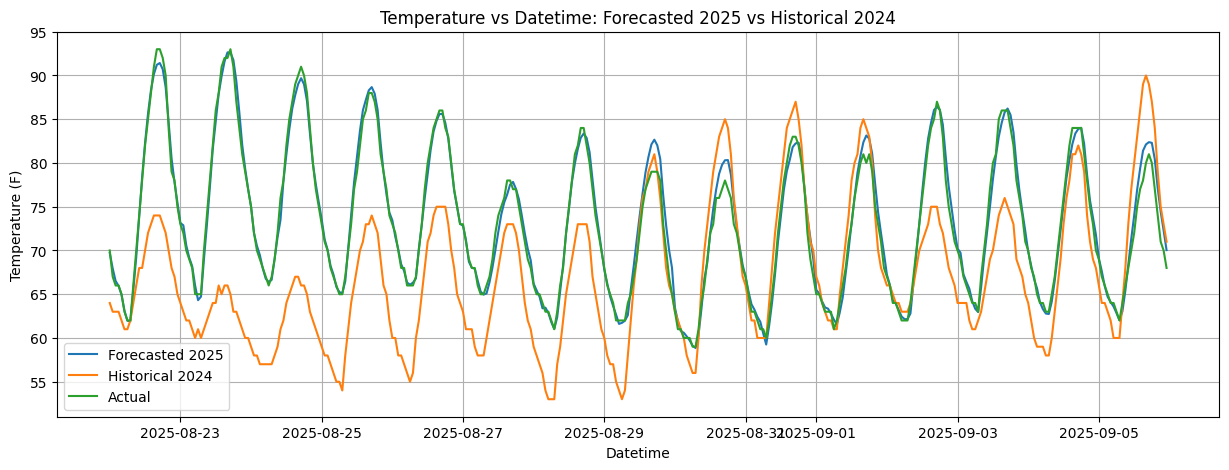

In [13]:
# Plot dfX['temperature'] vs dfX['datetime']
plt.figure(figsize=(15, 5))
plt.plot(dfX['datetime'], dfX['temperature'], label='Forecasted 2025')

# Filter dfhist for same time, date, month but year=2024
mask_2024 = (
    (dfhist['datetime'].dt.year == 2024) &
    (dfhist['datetime'].dt.month.isin(dfX['datetime'].dt.month)) &
    (dfhist['datetime'].dt.day.isin(dfX['datetime'].dt.day)) &
    (dfhist['datetime'].dt.hour.isin(dfX['datetime'].dt.hour))
)
dfhist_2024 = dfhist[mask_2024]
dfhist_2024['datetime2025'] = dfhist_2024['datetime'].apply(lambda dt: dt.replace(year=2025))

# Merge to get matching historical temperatures
merged = pd.merge(
    dfX[['datetime']],
    dfhist_2024[['datetime2025', 'temperature']],
    left_on='datetime',
    right_on='datetime2025',
    how='inner'
)

plt.plot(merged['datetime2025'], merged['temperature'], label='Historical 2024')
# Get actual historical temperature for the same datetimes as in dfX
actual_hist = pd.merge(
    dfX[['datetime']],
    dfhist[['datetime', 'temperature']],
    on='datetime',
    how='left'
)

plt.plot(actual_hist['datetime'], actual_hist['temperature'], label='Actual')

plt.xlabel('Datetime')
plt.ylabel('Temperature (F)')
plt.title('Temperature vs Datetime: Forecasted 2025 vs Historical 2024')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#data cleaning. TODO : construct a py file for this
#drop rows with temperature less than 0
# dfX = dfX[dfX['temperature'] >= 0]

KeyError: 'temperature'

In [6]:
dfX['year'] = dfX['datetime'].dt.year
dfX['month'] = dfX['datetime'].dt.month
dfX['date'] = dfX['datetime'].dt.day
dfX['day'] = dfX['datetime'].dt.dayofweek
dfX['time'] = dfX['datetime'].dt.hour

In [7]:
import joblib

# Load the saved model
model = joblib.load('models/Reg1modelscalerpoly.pkl')['model']
scaler = joblib.load('models/Reg1modelscalerpoly.pkl')['scaler']
poly = joblib.load('models/Reg1modelscalerpoly.pkl')['poly']

In [10]:
# Prepare features for prediction
features = ['time', 'day', 'month', 'temperature']
X_pred = dfX[features]

# Scale and transform features
X_pred_scaled = scaler.transform(X_pred)
X_pred_poly = poly.transform(X_pred_scaled)

# Predict using the trained model
dfX['predicted_load'] = model.predict(X_pred_poly)
dfX[['datetime', 'predicted_load']].head()

,datetime,predicted_load
75,2025-08-22 00:00:00,16452.418401
79,2025-08-22 01:00:00,14778.380017
83,2025-08-22 02:00:00,13890.042457
87,2025-08-22 03:00:00,13727.644961
91,2025-08-22 04:00:00,13762.593440


In [11]:
# Prepare features for prediction
features = ['time', 'day', 'month', 'feelsliketemp']
X_pred = dfX[features].rename(columns={"feelsliketemp": "temperature"})

# Scale and transform features
X_pred_scaled = scaler.transform(X_pred)
X_pred_poly = poly.transform(X_pred_scaled)

# Predict using the trained model
dfX['predicted_load_onfeelslike'] = model.predict(X_pred_poly)
dfX[['datetime', 'predicted_load_onfeelslike']].head()

,datetime,predicted_load_onfeelslike
75,2025-08-22 00:00:00,16445.785351
79,2025-08-22 01:00:00,14729.338830
83,2025-08-22 02:00:00,13890.042457
87,2025-08-22 03:00:00,13727.644961
91,2025-08-22 04:00:00,13758.112613


In [ ]:
dfX[['datetime','temperature', 'predicted_load', 'predicted_load_onfeelslike']]

,datetime,temperature,predicted_load,predicted_load_onfeelslike
75,2025-08-22 00:00:00,69.72,16452.418401,16445.785351
79,2025-08-22 01:00:00,67.95,14778.380017,14729.338830
83,2025-08-22 02:00:00,66.51,13890.042457,13890.042457
87,2025-08-22 03:00:00,65.95,13727.644961,13727.644961
91,2025-08-22 04:00:00,64.95,13762.593440,13758.112613
95,2025-08-22 05:00:00,63.13,13856.174175,13856.174175
99,2025-08-22 06:00:00,61.97,14217.659311,14217.659311
103,2025-08-22 07:00:00,61.92,14724.345191,14724.345191
107,2025-08-22 08:00:00,65.47,15523.699976,15523.699976
111,2025-08-22 09:00:00,69.24,16347.836080,16347.836080


In [15]:
#create date column from datetime, then group by date and take maximum of predicted_load and predicted_load_onfeelslike
dfX['date'] = dfX['datetime'].dt.date
daily_max = dfX.groupby('date')[['predicted_load', 'predicted_load_onfeelslike']].max().reset_index()

In [16]:
daily_max

,date,predicted_load,predicted_load_onfeelslike
0,2025-08-22,23997.853546,23196.619980
1,2025-08-23,23268.892015,22564.346724
2,2025-08-24,22391.509259,22154.064882
3,2025-08-25,23246.390320,22971.015732
4,2025-08-26,21989.410190,21856.911246
5,2025-08-27,19303.028919,19280.680972
6,2025-08-28,21364.225042,21247.561836
7,2025-08-29,20529.825606,20316.153955
8,2025-08-30,18906.052656,18669.497671
9,2025-08-31,19920.802213,19601.222892


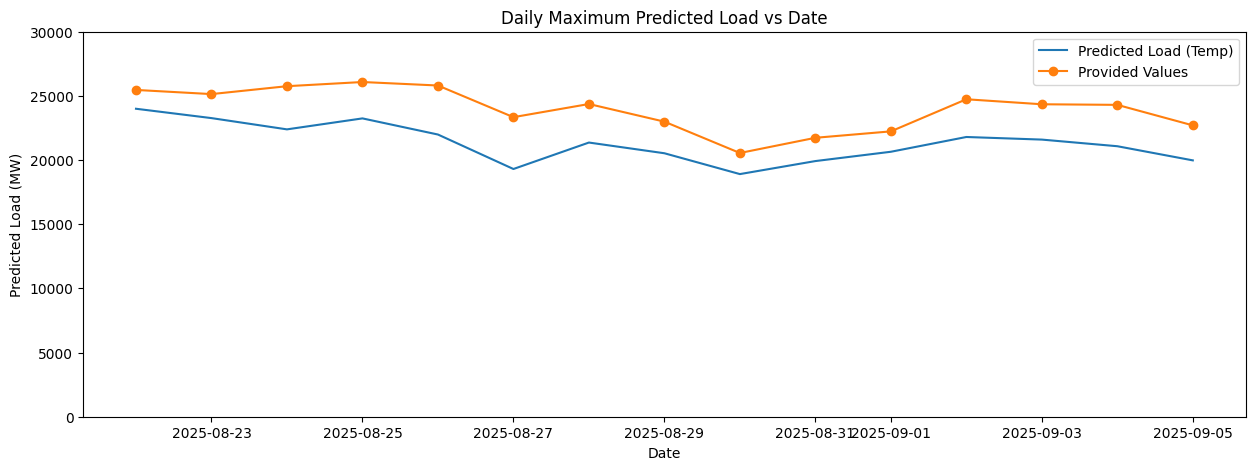

In [22]:
#plot predicted_load and predicted_load_onfeelslike vs date
plt.figure(figsize=(15, 5))
plt.plot(daily_max['date'], daily_max['predicted_load'], label='Predicted Load (Temp)')
plt.xlabel('Date')
plt.ylabel('Predicted Load (MW)')
plt.ylim(0, 30000)
plt.title('Daily Maximum Predicted Load vs Date')

import matplotlib.dates as mdates

# Create the data
dates = [
    "8/22/2025", "8/23/2025", "8/24/2025", "8/25/2025", "8/26/2025", "8/27/2025",
    "8/28/2025", "8/29/2025", "8/30/2025", "8/31/2025", "9/1/2025", "9/2/2025",
    "9/3/2025", "9/4/2025", "9/5/2025"
]
values = [
    25464, 25140, 25755, 26081, 25809, 23342, 24367, 22992,
    20550, 21735, 22235, 24737, 24347, 24301, 22703
]

# Convert dates to datetime
plot_dates = pd.to_datetime(dates)

# Plot
plt.plot(plot_dates, values, marker='o', label='Provided Values')
plt.legend()

In [25]:
#estimate R2 score between daily_max['predicted_load'] and plot_dates values
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(daily_max['predicted_load'], values)
average_load = daily_max['predicted_load'].mean()
mae_over_avg = mae / average_load
mae_over_avg

np.float64(0.12358783181248836)

In [24]:
r2

-1.4748043641355887e+30